#### Procesamiento Digital de Señales

# Tarea Semanal 10

#### Por Nahuel Braian Contreras

## Diseño de filtros
A partir de los parametros de la plantilla encontrados en la TS9, diseñaremos los filtros del tipo IIR y FIR y filtraremos la señal de ECG. Estos serán del tipo **Pasa Banda** y trataremos de asegurar una atenuación de 40dB en las frecuencias de corte, y un ripple lo mas pequeño posible.

Nota: Tener en cuenta que para el filtrado utilizaremos la función filtfilt que  aplica un doble filtrado a la señal, por lo que los parametros en el diseño seran las mitades de lo buscado.

### Filtro IIR
Diseñaremos un filtro Chebysheev tipo 2 asi aseguramos planicidad en la banda de paso y el ripple estara en las bandas donde no tiene importancia su distorsión.

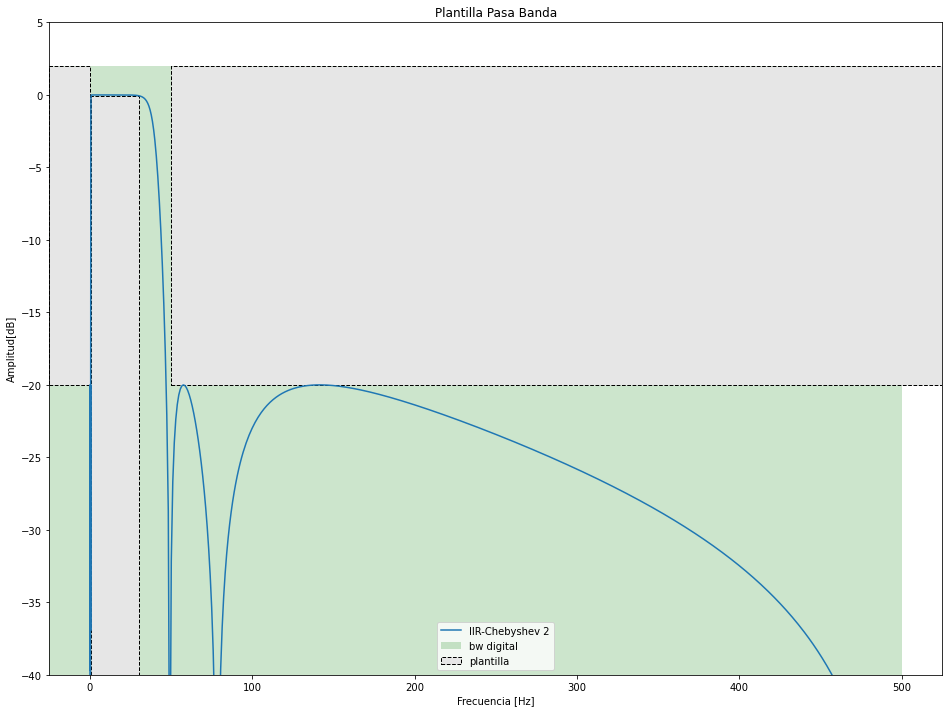

In [57]:
import scipy.signal as sig
import numpy as np
import matplotlib.pyplot as plt
from splane import plot_plantilla
import scipy.io as sio

mat_struct = sio.loadmat('ECG_TP4.mat')
ecg_one_lead = mat_struct['ecg_lead']

fs = 1000 # Hz
nyq_frec = fs / 2

# Como utilizaremos FiltFilt,el ripple y la atenuacion final seran el doble de la especificada
ripple = 0.05 # dB
alfa_min = 20 # dB

ws1 = 0.25 #Hz
wp1 = 0.75 #Hz
wp2 = 30 #Hz
ws2 = 50 #Hz

len_zeros = int(10e3)

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec

bp_sos_iir = sig.iirdesign([wp1, wp2], [ws1, ws2], ripple, alfa_min, analog=False,ftype= 'cheby2', output='sos', fs=fs)

w_rad  = np.append(np.logspace(-2, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w_rad  = np.append(w_rad, np.linspace(40, nyq_frec, 500, endpoint=True) ) / nyq_frec * np.pi
w = w_rad / np.pi * nyq_frec

_,h_filter = sig.sosfreqz(bp_sos_iir,worN=w_rad)

# cumplimos con la plantilla
plt.gcf().set_size_inches(16, 12)
plt.title("Plantilla Pasa Banda")
plt.plot(w, 20 * np.log10(abs(h_filter)), label='IIR-Chebyshev 2')
plt.ylim([-40,2])
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud[dB]")
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = alfa_min, fs = fs)

Podemos ver que cumplimos con la plantilla de diseño. Ahora aplicamos este filtro a la señal de ECG

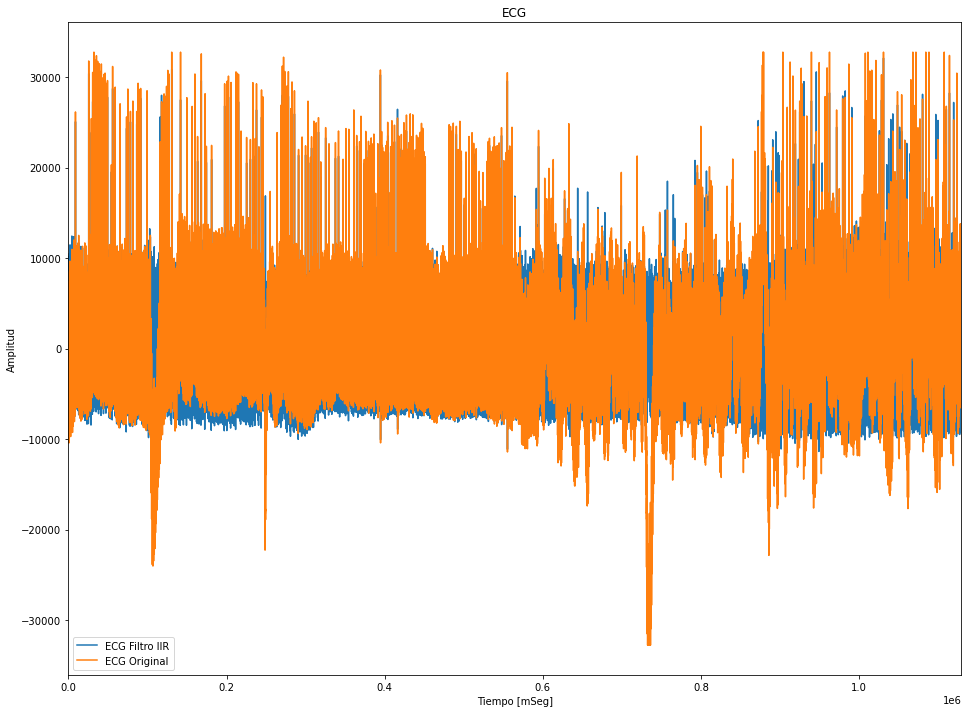

In [58]:
ECG_f_IIR = sig.sosfiltfilt(bp_sos_iir, ecg_one_lead, axis = 0)

plt.gcf().set_size_inches(16, 12)
plt.title("ECG")
plt.plot(ECG_f_IIR, label = "ECG Filtro IIR")
plt.plot(ecg_one_lead, label = "ECG Original")
plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()

Aqui podemos notar como la señal de ECG quedo pracitcamente planchada y no tenemos esos sobrepicos producidos por interferencias

### Filtro FIR
Diseñaremos un filtro FIR tipo cuadrados mínimos. Para el diseño del Pasa Banda, lo que hago es dividirlo en dos partes:

Por un lado, diseño la parte **Pasa Alto** con una mayor cantidad de coeficientes ya que la transición es muy exigente. Recordar que la frecuencia de corte inferior se encuentra en $fs_1 = 0.25Hz$ y la frecuencia de paso superior en $fp_1 = 0.75Hz$

Luego diseñaremos un filtro **Pasa Bajo** con una menor cantidad de coeficientes ya que la transición no es tan exigente. Este tendra una $fp_2 = 30Hz$ y una $fs_2 = 50Hz$

Finalmente haremos una convolución de ambos (sus numeradores), obteniendo asi el filtro **Pasa Banda** deseado

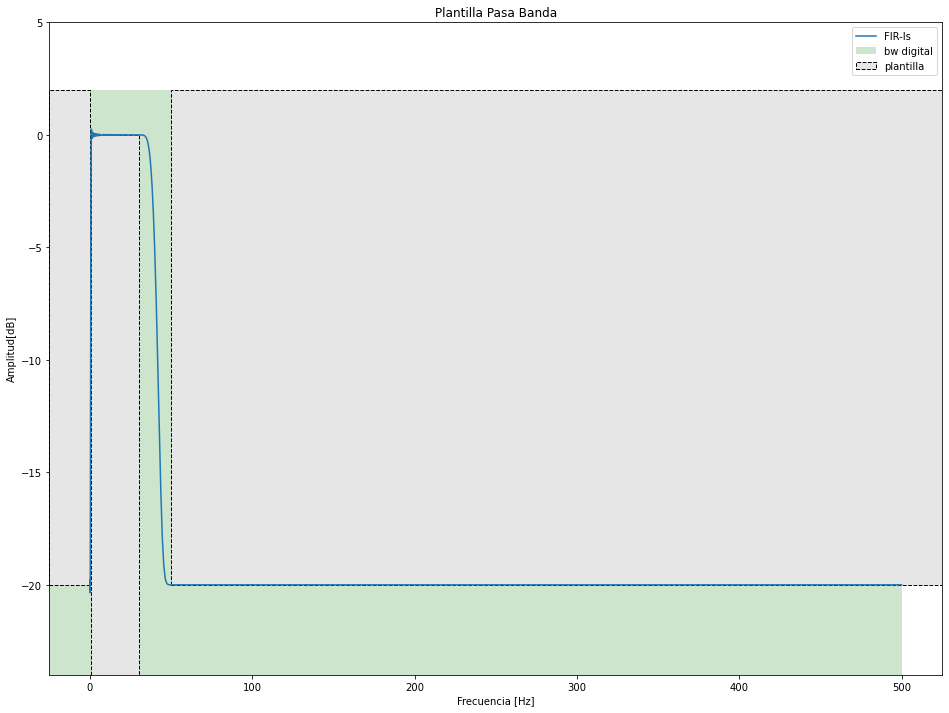

In [59]:
# Utilizo el filtro FIR del tipo cuadrados minimos

ripple = 0 # dB
atenuacion = 20 # dB

fs_n = fs/nyq_frec

# vector de frecuencias necesarias para el diseño
frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec

# ganancias deseadas
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion]) # dB
gains = 10**(gains/20) # Veces

# diseño pasa alto
ls_bands_hp = np.append(frecs[:3],[1.0])
ls_desired_hp = np.append(gains[:3],[1.0])
ls_weight_hp = np.array([20, 1])

cant_coef = 3000    # Esta parte es mas exigente, por eso requiero mas coeficientes
if cant_coef % 2 == 0:
    cant_coef += 1
    

num_firls_hp = sig.firls(cant_coef, ls_bands_hp, ls_desired_hp, weight = ls_weight_hp, fs=fs_n)

# diseño pasa bajo
ls_band_lp = np.append([0.0],frecs[3:])
ls_desired_lp = np.append([1.0],gains[3:])
ls_weight_lp = np.array([5, 10])
cant_coef = 500 # Menor exigencia, menor cantidad de coeficientes

if cant_coef % 2 == 0:
    cant_coef += 1

num_firls_lp = sig.firls(cant_coef, ls_band_lp, ls_desired_lp, weight = ls_weight_lp, fs=fs_n)

# diseño pasa banda : Union de pasa alto y pasa bajo
w_rad  = np.append(np.logspace(-2, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w_rad  = np.append(w_rad, np.linspace(40, nyq_frec, 500, endpoint=True) ) / nyq_frec * np.pi
w = w_rad / np.pi * nyq_frec

num_firls_bp = np.convolve(num_firls_lp, num_firls_hp)
den_fir = 1.0

_, h_firls_bp = sig.freqz(num_firls_bp, den_fir,w_rad)

# cumplimos con la plantilla
plt.gcf().set_size_inches(16, 12)
plt.title("Plantilla Pasa Banda")
plt.plot(w, 20 * np.log10(abs(h_firls_bp)), label='FIR-ls')
plt.ylim([-24,2])
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud[dB]")
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)


Cumplimos la plantilla de diseño, ahora se lo aplicamos a nuestra señal de ECG

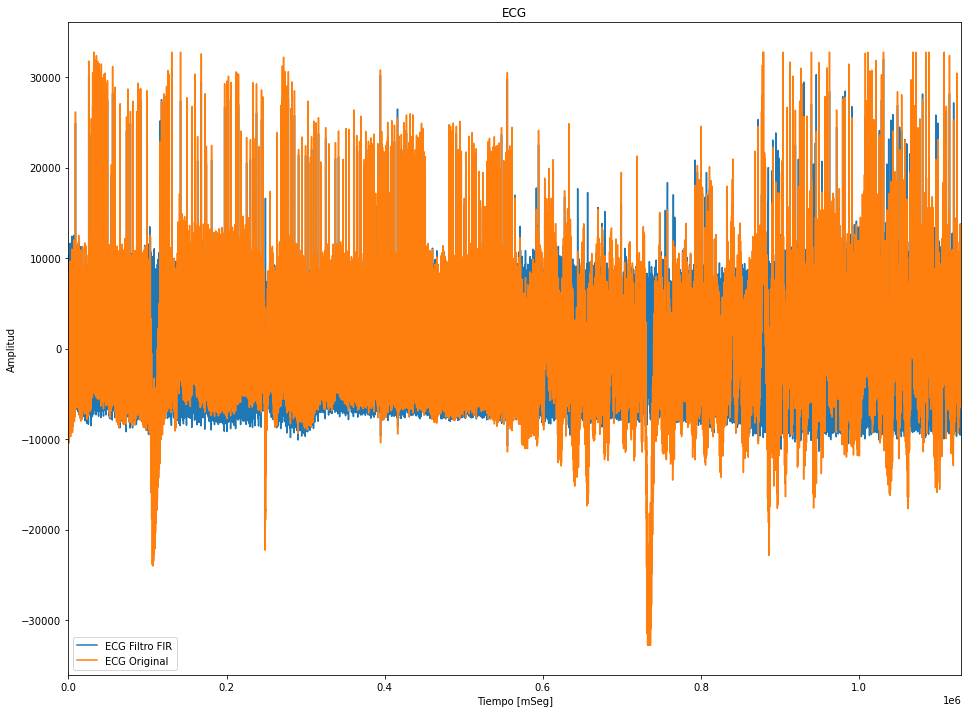

In [60]:
ECG_f_FIR = sig.filtfilt(num_firls_bp, den_fir, ecg_one_lead,axis = 0)
plt.gcf().set_size_inches(16, 12)
plt.title("ECG")
plt.plot(ECG_f_FIR, label = "ECG Filtro FIR")
plt.plot(ecg_one_lead, label = "ECG Original")
plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()

Tal como ocurrio con el filtro FIR, podemos notar una señal de ECG mas limpia.

### Comparación de ambos filtros

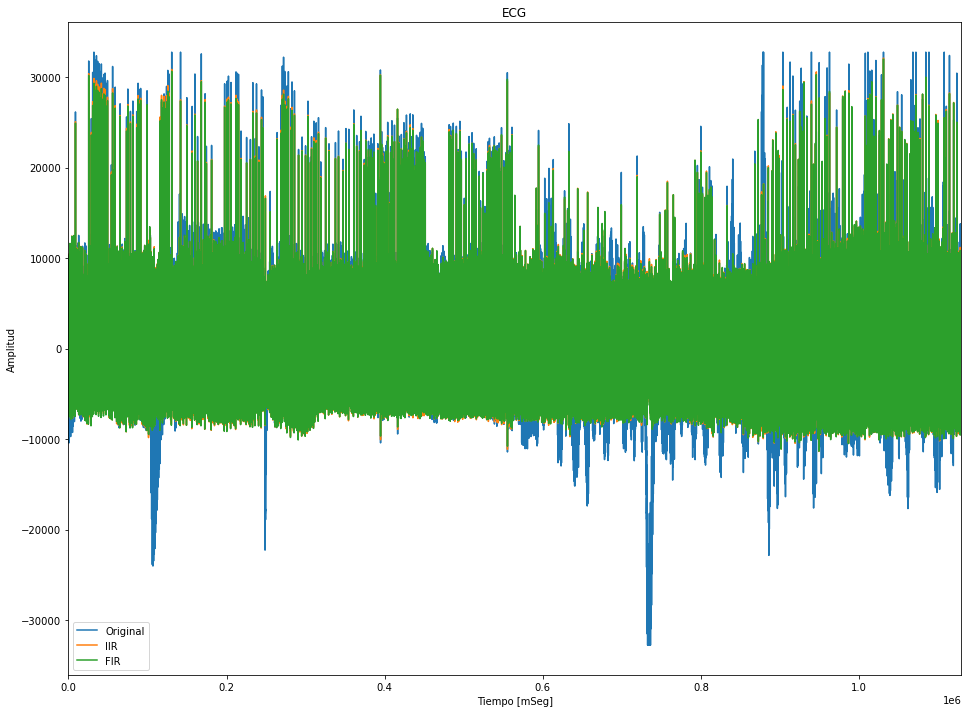

In [61]:
plt.gcf().set_size_inches(16, 12)
plt.title("ECG")
plt.plot(ecg_one_lead, label = "Original")
plt.plot(ECG_f_IIR, label = "IIR")
plt.plot(ECG_f_FIR, label = "FIR")
plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()

Mirando la señal completa observamos que ambos filtros cumplieron su trabajo. Analicemos como se comportan en las distintas secciones

### Caso Reposo

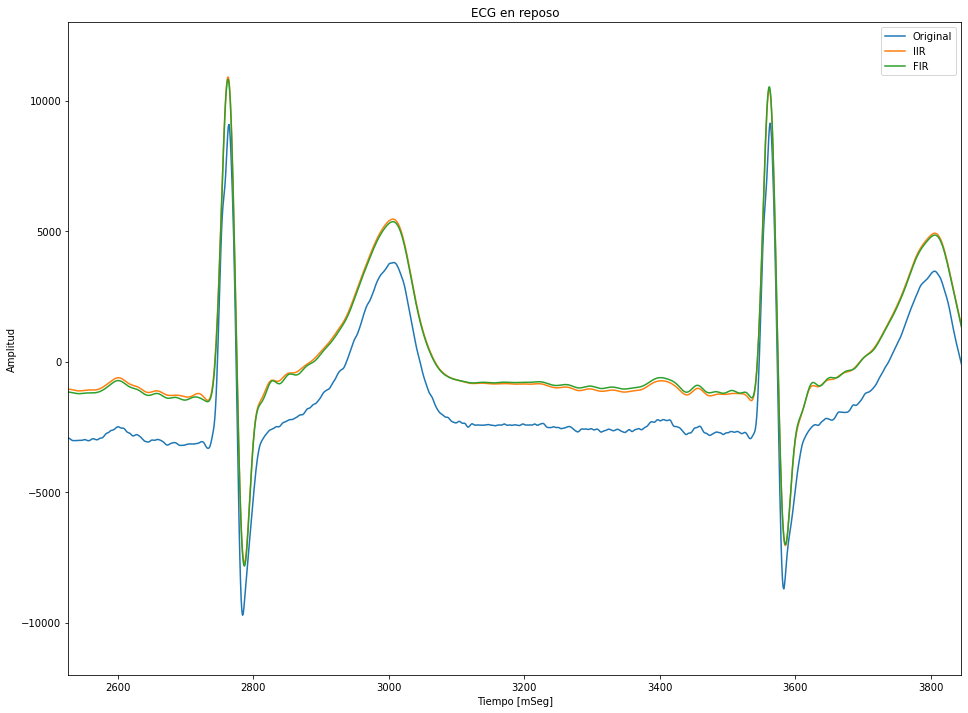

In [62]:
plt.gcf().set_size_inches(16, 12)
plt.title("ECG en reposo")
plt.plot(ecg_one_lead, label = "Original")
plt.plot(ECG_f_IIR, label = "IIR")
plt.plot(ECG_f_FIR, label = "FIR")
plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
plt.xlim([2527,3845])
plt.ylim([-12000,13000])
plt.legend()

Ambos filtros eliminaron un pequeño nivel de offeset de la señal original. Igualmente al estar en un caso de reposo, las interferencias externas no son ven tan reflejadas. 

Sin embargo veremos algunos casos interesantes que nuestros filtros lograron eliminar

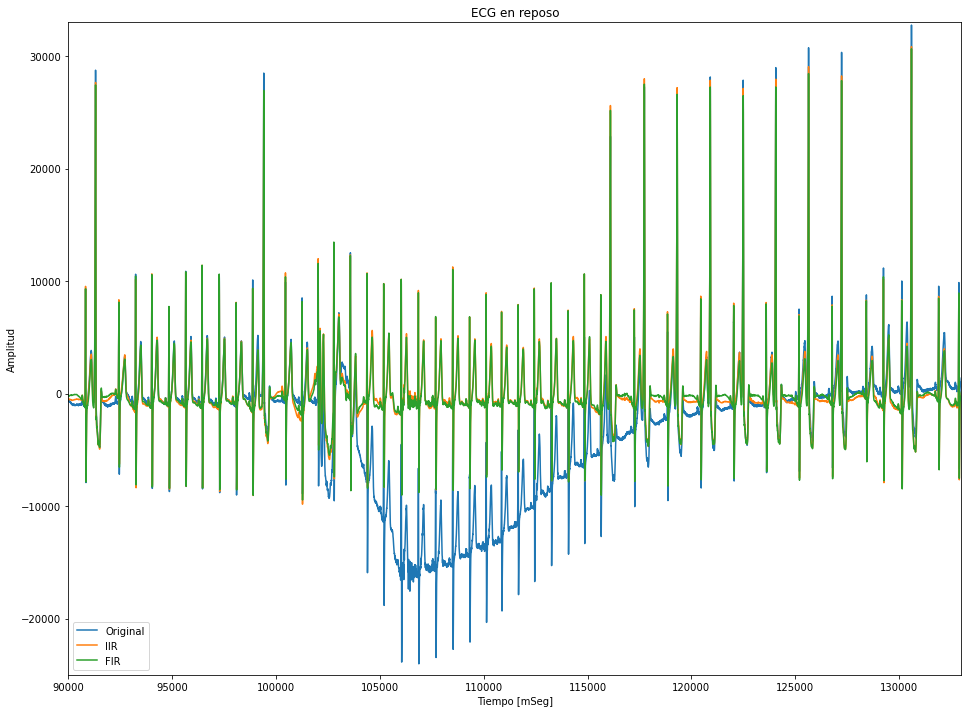

In [63]:
plt.gcf().set_size_inches(16, 12)
plt.title("ECG en reposo")
plt.plot(ecg_one_lead, label = "Original")
plt.plot(ECG_f_IIR, label = "IIR")
plt.plot(ECG_f_FIR, label = "FIR")
plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
plt.xlim([90000,133000])
plt.ylim([-25000,33000])
plt.legend()

En esta zona estamos por entrar al rango de ejercicio, pero podemos notar como eliminamos esa interferencia dejando a la señal ECG sin alterar.

### Caso Ejercicio

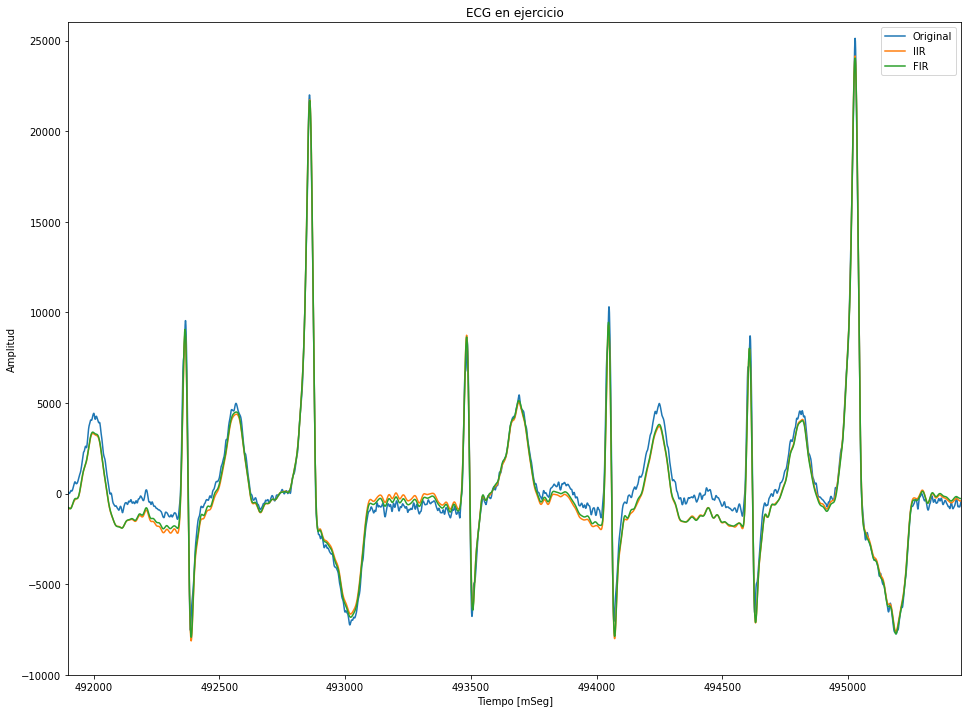

In [64]:
plt.gcf().set_size_inches(16, 12)
plt.title("ECG en ejercicio")
plt.plot(ecg_one_lead, label = "Original")
plt.plot(ECG_f_IIR, label = "IIR")
plt.plot(ECG_f_FIR, label = "FIR")
plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
plt.xlim([491900,495450])
plt.ylim([-10000,26000])
plt.legend()

En la zona de ejercicio notamos que la señal filtrado matiene la forma de la ECG, dejando la señal un poco mas suave sin tanto ruido de alta frecuencia. 

En la transición a la zona de mayor esfuerzo, tambien logramos filtrar interferencias.

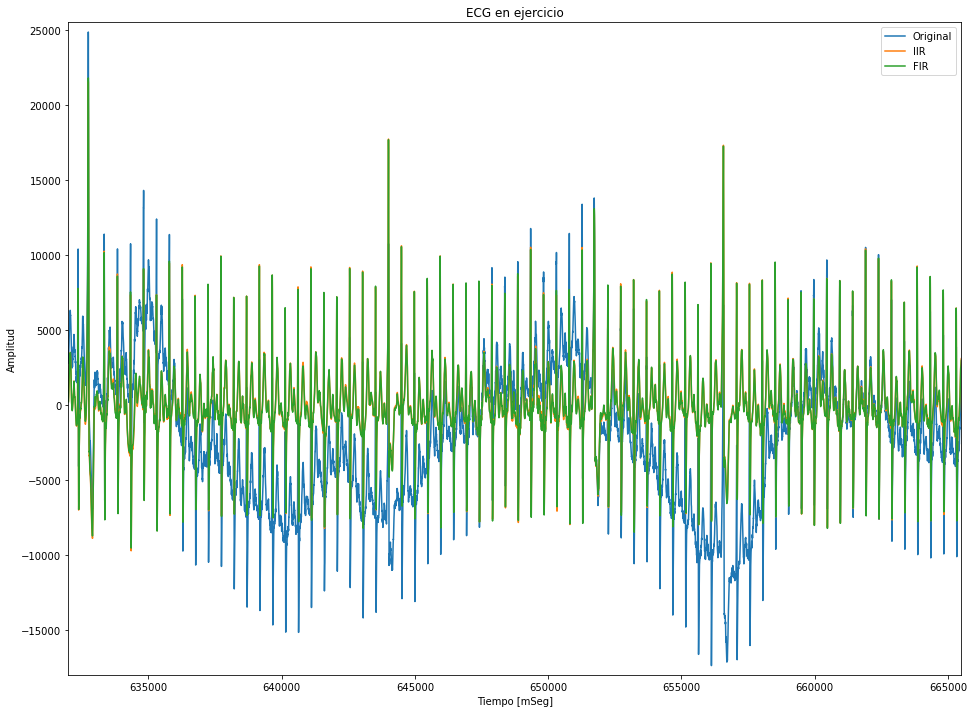

In [65]:
plt.gcf().set_size_inches(16, 12)
plt.title("ECG en ejercicio")
plt.plot(ecg_one_lead, label = "Original")
plt.plot(ECG_f_IIR, label = "IIR")
plt.plot(ECG_f_FIR, label = "FIR")
plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
plt.xlim([632000,665500])
plt.ylim([-18000,25500])
plt.legend()

### Caso pico de Esfuerzo

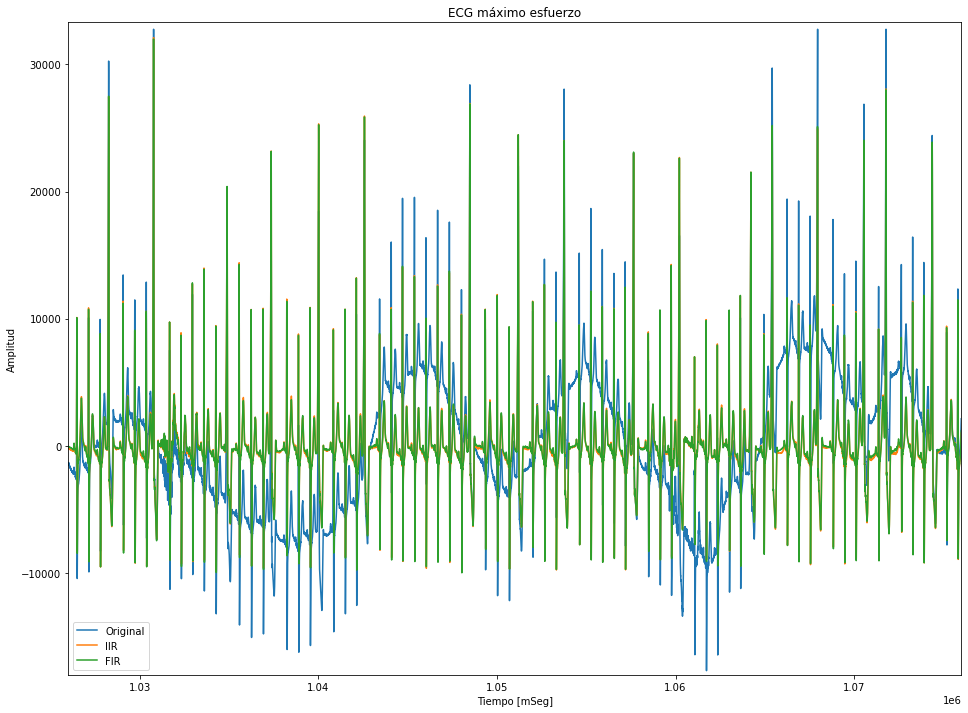

In [66]:
plt.gcf().set_size_inches(16, 12)
plt.title("ECG máximo esfuerzo")
plt.plot(ecg_one_lead, label = "Original")
plt.plot(ECG_f_IIR, label = "IIR")
plt.plot(ECG_f_FIR, label = "FIR")
plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
plt.xlim([1026000,1076000])
plt.ylim([-18000,33300])
plt.legend()

Como esperabamos, ambos filtros funcionaron de manera correcta, sin eliminar información de la señal de ECG

## Análisis de la densidad espectral de potencia

En la TS9 analizamos como calcular la densidad espectral de potencia, y a partir de el encontramos algunos parametros que utilizamos para el diseño de nuestra plantilla. A continuación veremos que aspecto tiene luego de aplicar ambos filtros.

### Caso IIR

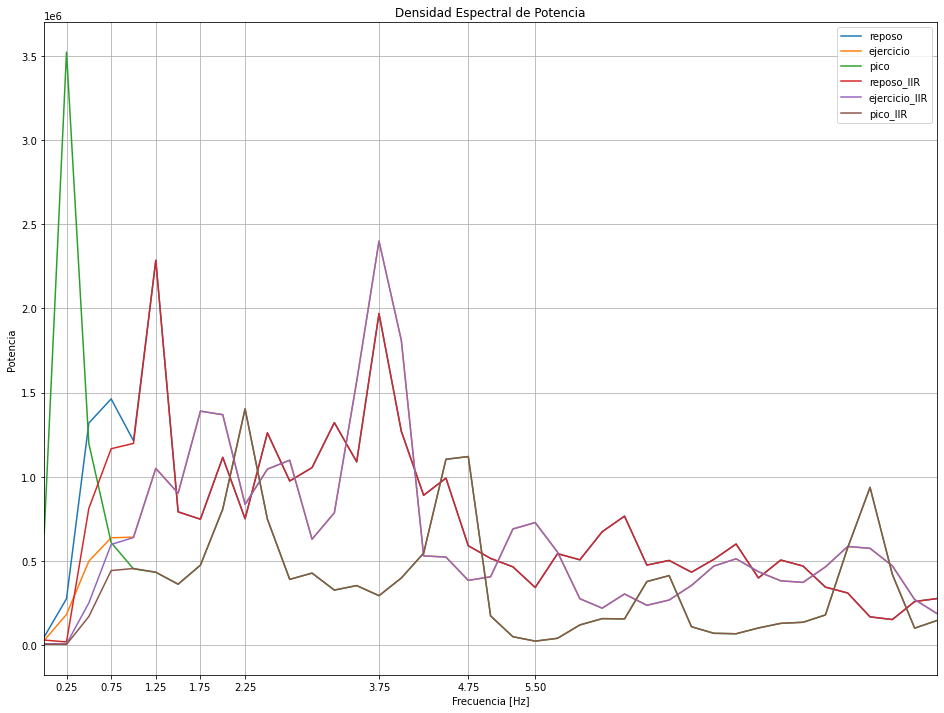

In [71]:
fs = 1000
n = [100, 300, 760, 1000, 4000]

##SEÑAL ORIGINAL
#Analizando la señal de ECG podemos notar que el paciente en esta seccion estuvo en reposo
ECG_reposo = (ecg_one_lead[0:100000])
[f, PXX_pot_reposo] = sig.welch(ECG_reposo, fs = fs,nperseg = n[4], axis = 0)

#En esta sección los latido van reduciendo su período
ECG_reposo_ejercicio = (ecg_one_lead[450000:550000])
[f, PXX_pot_ejercicio] = sig.welch(ECG_reposo_ejercicio, fs = fs,nperseg = n[4], axis = 0)

#Los latidos son mas rapidos
ECG_peak = (ecg_one_lead[750000:850000])
[f, PXX_pot_peak] = sig.welch(ECG_peak, fs = fs,nperseg = n[4], axis = 0)

## FILTRO IIR APLICADO
ECG_IIR_reposo = (ECG_f_IIR[0:100000])
[f, PXX_IIR_reposo] = sig.welch(ECG_IIR_reposo, fs = fs,nperseg = n[4], axis = 0)

ECG_IIR_ejercicio = (ECG_f_IIR[450000:550000])
[f, PXX_IIR_ejercicio] = sig.welch(ECG_IIR_ejercicio, fs = fs,nperseg = n[4], axis = 0)


ECG_IIR_peak = (ECG_f_IIR[750000:850000])
[f, PXX_IIR_peak] = sig.welch(ECG_IIR_peak, fs = fs,nperseg = n[4], axis = 0)

plt.gcf().set_size_inches(16, 12)
plt.title("Densidad Espectral de Potencia")
plt.plot(f, (PXX_pot_reposo), label = 'reposo')
plt.plot(f, (PXX_pot_ejercicio), label = 'ejercicio')
plt.plot(f, (PXX_pot_peak), label = 'pico')
plt.plot(f, (PXX_IIR_reposo), label = 'reposo_IIR')
plt.plot(f, (PXX_IIR_ejercicio), label = 'ejercicio_IIR')
plt.plot(f, (PXX_IIR_peak), label = 'pico_IIR')
plt.xlim([0,10])
plt.xticks([0.25,0.75,1.25,1.75,2.25,3.75,4.75,5.5])
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia")
plt.grid()
plt.legend()

Podemos notar que practicamente eliminamos la interferencia que se producia en $f = 0,25Hz$. Despues practicamente el grafico no se ve afectado.

Ahora analicemos los graficos en dB

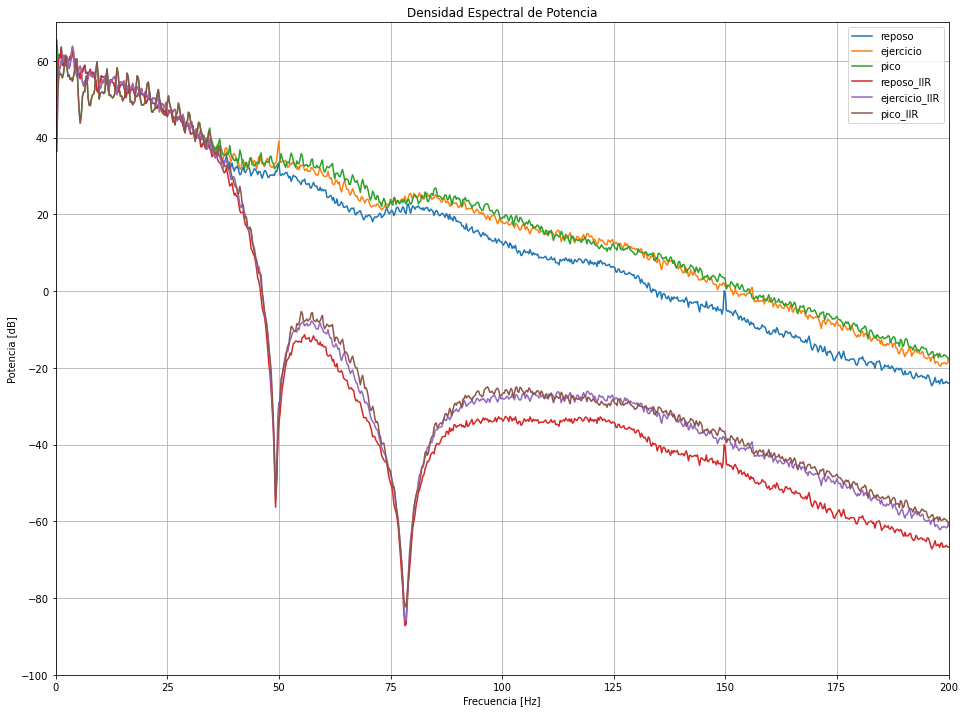

In [72]:
plt.gcf().set_size_inches(16, 12)
plt.title("Densidad Espectral de Potencia")
plt.plot(f, 10*np.log10(PXX_pot_reposo), label = 'reposo')
plt.plot(f, 10*np.log10(PXX_pot_ejercicio), label = 'ejercicio')
plt.plot(f, 10*np.log10(PXX_pot_peak), label = 'pico')
plt.plot(f, 10*np.log10(PXX_IIR_reposo), label = 'reposo_IIR')
plt.plot(f, 10*np.log10(PXX_IIR_ejercicio), label = 'ejercicio_IIR')
plt.plot(f, 10*np.log10(PXX_IIR_peak), label = 'pico_IIR')
plt.xlabel("Frecuencia [Hz]")
plt.ylabel('Potencia [dB]')
plt.xlim([0,200])
plt.ylim([-100,70])
plt.grid()
plt.legend()

Notamos que $f = 30Hz$ la señal filtrada comienza a atenuarse, produciendose una fuerte atenuacion (casi como un filtro notch) en $f = 50Hz$ debido a la naturaleza del Chebyshev.

### Caso FIR
Repetiremos los mismos cálculos para el filtro FIR

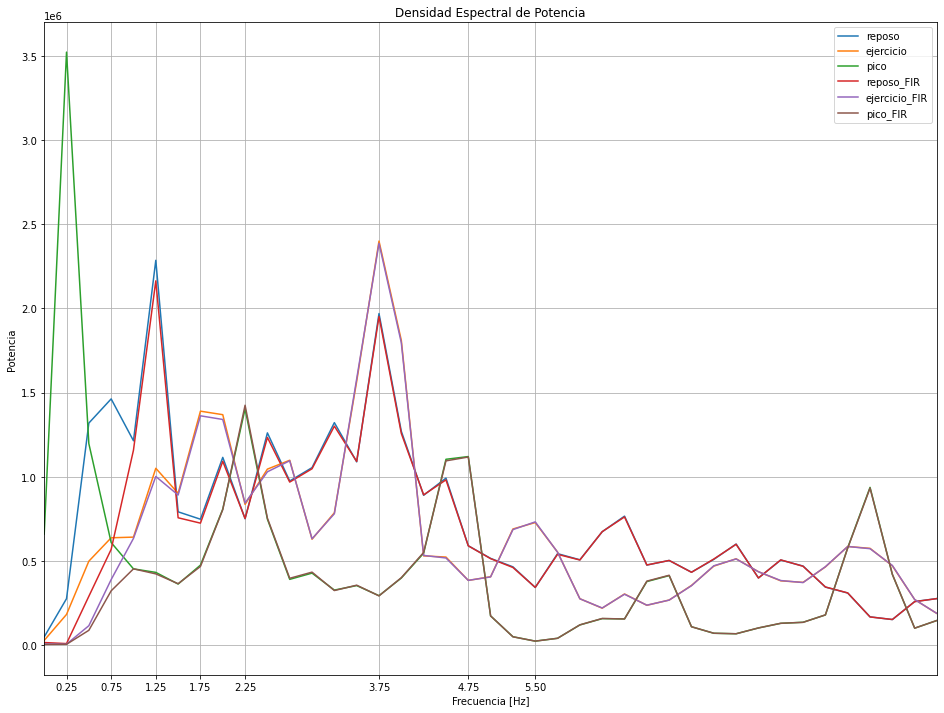

In [73]:
## FILTRO FIR APLICADO
ECG_FIR_reposo = (ECG_f_FIR[0:100000])
[f, PXX_FIR_reposo] = sig.welch(ECG_FIR_reposo, fs = fs,nperseg = n[4], axis = 0)

ECG_FIR_ejercicio = (ECG_f_FIR[450000:550000])
[f, PXX_FIR_ejercicio] = sig.welch(ECG_FIR_ejercicio, fs = fs,nperseg = n[4], axis = 0)

ECG_FIR_peak = (ECG_f_FIR[750000:850000])
[f, PXX_FIR_peak] = sig.welch(ECG_FIR_peak, fs = fs,nperseg = n[4], axis = 0)

plt.gcf().set_size_inches(16, 12)
plt.title("Densidad Espectral de Potencia")
plt.plot(f, (PXX_pot_reposo), label = 'reposo')
plt.plot(f, (PXX_pot_ejercicio), label = 'ejercicio')
plt.plot(f, (PXX_pot_peak), label = 'pico')
plt.plot(f, (PXX_FIR_reposo), label = 'reposo_FIR')
plt.plot(f, (PXX_FIR_ejercicio), label = 'ejercicio_FIR')
plt.plot(f, (PXX_FIR_peak), label = 'pico_FIR')
plt.xlim([0,10])
plt.xticks([0.25,0.75,1.25,1.75,2.25,3.75,4.75,5.5])
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia")
plt.grid()
plt.legend()

En este caso tambien eliminamos correctamente la interferencia producida en $f = 0,25Hz$, aunque existe una pequeña variación con respecto a las señales originales en las frecuencias iniciales, produciendose la mayor variacion en el caso de reposo

Ahora analicemos los graficos en dB

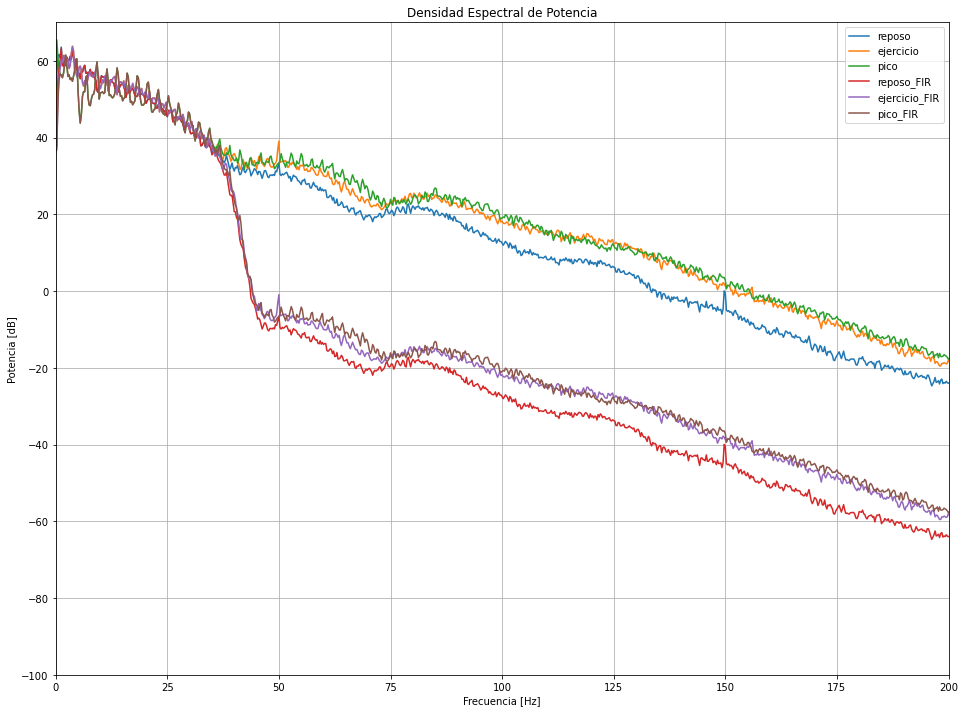

In [74]:
plt.gcf().set_size_inches(16, 12)
plt.title("Densidad Espectral de Potencia")
plt.plot(f, 10*np.log10(PXX_pot_reposo), label = 'reposo')
plt.plot(f, 10*np.log10(PXX_pot_ejercicio), label = 'ejercicio')
plt.plot(f, 10*np.log10(PXX_pot_peak), label = 'pico')
plt.plot(f, 10*np.log10(PXX_FIR_reposo), label = 'reposo_FIR')
plt.plot(f, 10*np.log10(PXX_FIR_ejercicio), label = 'ejercicio_FIR')
plt.plot(f, 10*np.log10(PXX_FIR_peak), label = 'pico_FIR')
plt.xlabel("Frecuencia [Hz]")
plt.ylabel('Potencia [dB]')
plt.xlim([0,200])
plt.ylim([-100,70])
plt.grid()
plt.legend()

Notamos que $f = 30Hz$ la señal filtrada comienza a atenuarse, y a partir de $f = 50Hz$ tenemos una atenuación constante de 40dB, respetando lo visto en la plantilla de diseño